# Analysis of Google Play Store Reviews on CCINext App

In [1]:
import pandas as pd
import numpy as np
import regex as re

import plotly.express as px

from google_play_scraper import Sort, reviews_all
from wordcloud import WordCloud
from nltk.corpus import stopwords
from snowballstemmer import TurkishStemmer
from PIL import Image
from turkishnlp import detector

from matplotlib import pyplot as plt

In [2]:
# Pull comments from Play Store using the library google_play_scraper
# This function only returns reviews with contents/comments.
app_id = 'com.cci.ccinext'
tr_reviews = reviews_all(
                app_id, # id of the app from the play store
                lang='tr',
                country='tr',
                sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT but we will use Sort.NEWEST
            )

In [3]:
reviewscol = ['content', 'score', 'reviewCreatedVersion', 'at']

df = pd.DataFrame(tr_reviews, columns=reviewscol)

df["month"] = df['at'].map(lambda x: x.month)
df["year"] = df['at'].map(lambda x: x.year)

df = df.sort_values('at')
df

,content,score,reviewCreatedVersion,at,month,year
548,Coca-Cola İçecek geleceğe koşuyor,5,1.0.0,2017-03-14 12:49:39,3,2017
547,"Müşteri numarasını yazıyorum ama hatalı diyor,...",1,1.1.0,2017-05-24 11:33:48,5,2017
546,2500 puani yediniz,5,1.2.0,2017-07-11 14:48:47,7,2017
545,Çok güzel,5,1.2.0,2017-07-14 15:30:16,7,2017
559,Süper 👍,5,None,2017-08-08 22:10:07,8,2017
...,...,...,...,...,...,...
400,Y. J. Kı h,3,3.17.0,2023-07-09 22:57:34,7,2023
2,Online den sipariş veriyorum adamlar kafaların...,1,4.3.2,2023-07-15 17:51:44,7,2023
0,Ana sayfa beyaz bir sayfada kalıyor. Sildim yü...,1,183 (4.3.3),2023-08-01 01:43:50,8,2023
165,Berbat Bir uygulama,1,184 (4.3.3),2023-08-25 21:00:15,8,2023


In [4]:
df.to_excel("export_dataframe.xlsx", index=False)

In [5]:
avg_score = np.average(df['score'])
print("Average Review Score (over 5): " + str(round(avg_score, 2)))

Average Review Score (over 5): 2.35


In [6]:
score_df = df.groupby('score').count().reset_index()

fig = px.pie(score_df,
             values = "content",
             names = "score",
             color_discrete_sequence=px.colors.sequential.Agsunset,
             title='Distribution of The Ratings to The CCINext App on Google Play Store')
fig.update_traces(sort=False) 
fig.show()

In [7]:
year_month_reviews = df.groupby(['year'])['score'].mean().reset_index()

fig = px.bar(year_month_reviews,
             x = "year",
             y = "score",
             labels={
                 "year": "Years",
                 "score": "Average Scores"
             },
             text_auto='.2s',
             color_discrete_sequence=px.colors.sequential.Sunset_r,
             title='Yearly Averages of The Ratings for CCINext App on Google Play Store')
fig.show()

In [8]:
year_month_avg = df.groupby(['year', 'month'])['score'].agg(["mean", "count"]).reset_index()

year_month_avg['date'] = pd.to_datetime(dict(year=year_month_avg.year, month=year_month_avg.month, day=1))
                                                                  

As we see in the grapgh below, the number of reviews on the application has decreased recently. Considering that people who comment generally do so for complaint purposes, this may be due to a decrease in complaints about the app. But if we also consider that the average score has decreased, this may indicate that the app is used less. More research is needed on this subject.

In [9]:
fig = px.scatter(year_month_avg,
                 x = "date",
                 y = "mean",
	             size="count",
                 color="count",
                 size_max=60,
                 labels={
                     "mean": "Average Review Scores",
                     "x": "Time",
                     "count": "Review Count"
                 },
                 title = "Average Review Scores and Counts (March 2017 - present)")
fig.show()

c:\Users\sahin\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [10]:
df.replace("183 (4.3.3)", "4.3.3", inplace=True)
df.replace("184 (4.3.3)", "4.3.3", inplace=True)

version_df = df.groupby(["reviewCreatedVersion"])["score"].agg(["mean", "count"]).reset_index()
version_df = version_df[version_df["count"] >= 10]
# I excluded the versions with less than 10 reviews for consistency.

fig = px.bar(version_df,
            x = "reviewCreatedVersion",
            y = "mean",
            labels={
                "reviewCreatedVersion": "App Version",
                "mean": "Average Ratings"
            },
            text_auto='.2s',
            color_discrete_sequence=px.colors.sequential.Sunset_r,
            title='Average Ratings for CCINext App on Google Play Store by App Version')
fig.show()

Recently, all versions except the version 3.7.3 have received ratings below 3/5. The underlying reasons for this should be investigated.

In [11]:
# Combines seperate reviews into a single text.
def merge_reviews(arr):
    text = " ".join(review for review in arr)

    return text

In [12]:
# Creates Word Cloud from a text. The shape of the cloud is in the form of the CCI logo but this can be changed.
def create_cloud(text, bg="CCI_Logo.jpg"):
    cci_mask = np.array(Image.open(bg))

    words = re.sub(r'[^\w\s]','',text.lower()).split()
    words_without_sw = [word for word in words if not word in stopwords.words('turkish')]
    cleaned_text = (' ').join(words_without_sw)

    #stemmer = TurkishStemmer()
    #cleaned = stemmer.stemWords(cleaned_text.split())
    # I decided not to use stemmer because there were too many meaningless words

    plt.figure(figsize=(12,12))
    cloud = WordCloud(width = 1200,
                      height = 600,
                      mask = cci_mask,
                      max_font_size = 200,
                      min_font_size = 25,
                      colormap = "plasma", # twilight_shifted dene
                      )
    #plt.imshow(cloud.generate(' '.join(cleaned)))
    plt.imshow(cloud.generate(cleaned_text))
    plt.axis("off")

In [13]:
reviews_text = merge_reviews(df.content)

In [14]:
obj = detector.TurkishNLP()
#obj.download()   --> Download required when running the code for the first time
obj.create_word_set()
lwords = obj.list_words(reviews_text)
corrected_words = obj.auto_correct(lwords)


In [15]:
# Idecided to delete the words with less than 3 letters
j=0
for i in range(len(corrected_words)):
    if len(corrected_words[j])<4:
        del corrected_words[j]
        j -= 1
    j += 1

In [16]:
corrected_text = " ".join(corrected_words)

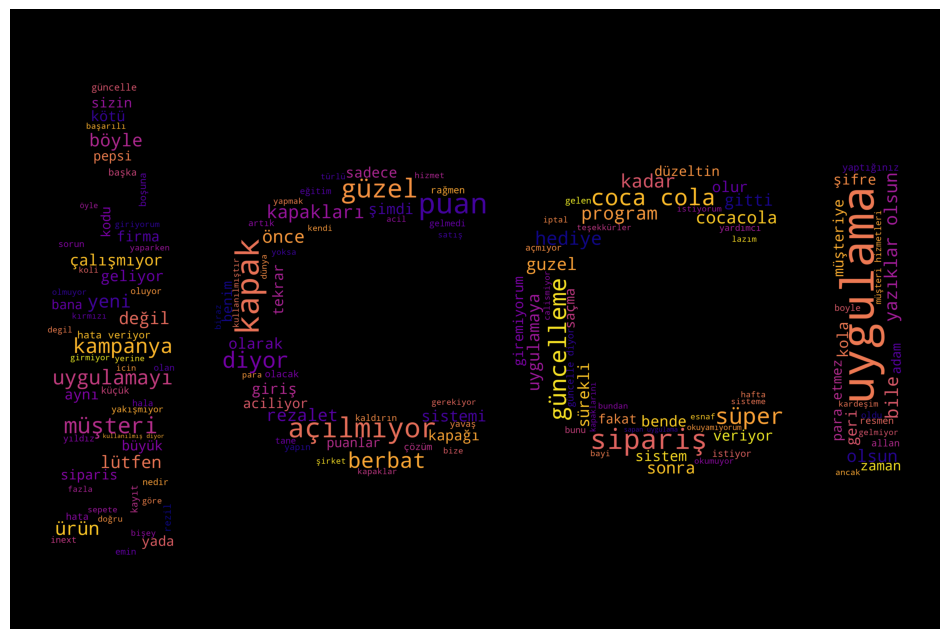

In [17]:
create_cloud(corrected_text)

Let's mark some keywords. The image below may be different from the one above, but the resulting words and their sizes are the same.

<img src="ccinext_wordcloud.png" />

Problems of the CCINext application:
- There are some problems with the code on the cap of the bottle. For example, it takes a lot of time to scan the codes.
- Some people are not satisfied with the special offers.
- There are a lot of people saying that their points were deleted.